In [135]:
import pickle
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score


In [136]:
model_pathLRNeo = '../model/pickle_Crossvalidation/LogisticRegression/gptNeo_model.pkl'
model_pathRFNeo = '../model/pickle_Crossvalidation/RandomForest/gptNeo_model.pkl'
model_pathSVMNeo = '../model/pickle_Crossvalidation/LogisticRegression/gptNeo_model.pkl'

model_pathLRLlama = '../model/pickle_Crossvalidation/LogisticRegression/llama3_model.pkl'
model_pathRFLlama = '../model/pickle_Crossvalidation/RandomForest/llama3_model.pkl'
model_pathSVMLlama = '../model/pickle_Crossvalidation/LogisticRegression/llama3_model.pkl'

model_pathLRMistral = '../model/pickle_Crossvalidation/LogisticRegression/mistral_model.pkl'
model_pathRFMistral = '../model/pickle_Crossvalidation/RandomForest/mistral_model.pkl'
model_pathSVMMistral = '../model/pickle_Crossvalidation/LogisticRegression/mistral_model.pkl'

In [137]:
data = pd.read_csv('../../../preprocessing/StorePreprocessed/GPT35csv.csv')

data = data.dropna(subset=["text", "label"])

X = data["text"]
y = data["label"]

vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(4, 4), max_features=11000)

X_test = vectorizer.fit_transform(X)
y_test = y

In [138]:
if os.path.exists(model_pathLRNeo) and os.path.exists(model_pathRFNeo) and os.path.exists(model_pathSVMNeo):
    with open(model_pathLRNeo, 'rb') as lr:
        lr_bestNeo = pickle.load(lr)
    with open(model_pathRFNeo, 'rb') as rf:
        rf_bestNeo = pickle.load(rf)
    with open(model_pathSVMNeo, 'rb') as svm:
        svm_bestNeo = pickle.load(svm)
else:
    print('Model Neo not found')
    exit(1)

if os.path.exists(model_pathLRLlama) and os.path.exists(model_pathRFLlama) and os.path.exists(model_pathSVMLlama):
    with open(model_pathLRLlama, 'rb') as lr:
        lr_bestLlama = pickle.load(lr)
    with open(model_pathRFLlama, 'rb') as rf:
        rf_bestLlama = pickle.load(rf)
    with open(model_pathSVMLlama, 'rb') as svm:
        svm_bestLlama = pickle.load(svm)
else:
    print('Model Llama3 not found')
    exit(1)

if os.path.exists(model_pathLRMistral) and os.path.exists(model_pathRFMistral) and os.path.exists(model_pathSVMMistral):
    with open(model_pathLRMistral, 'rb') as lr:
        lr_bestMistral = pickle.load(lr)
    with open(model_pathRFMistral, 'rb') as rf:
        rf_bestMistral = pickle.load(rf)
    with open(model_pathSVMMistral, 'rb') as svm:
        svm_bestMistral = pickle.load(svm)
else:
    print('Model Llama3 not found')
    exit(1)

In [139]:
y_pred_lrNeo = lr_bestNeo.predict(X_test)
y_pred_rfNeo = rf_bestNeo.predict(X_test)
y_pred_svmNeo = svm_bestNeo.predict(X_test)

y_pred_lrLlama = lr_bestLlama.predict(X_test)
y_pred_rfLlama = rf_bestLlama.predict(X_test)
y_pred_svmLlama = svm_bestLlama.predict(X_test)

y_pred_lrMistral = lr_bestMistral.predict(X_test)
y_pred_rfMistral = rf_bestMistral.predict(X_test)
y_pred_svmMistral = svm_bestMistral.predict(X_test)

In [140]:
# Mayority Voting
predictionsNeo = np.array([y_pred_lrNeo, y_pred_rfNeo, y_pred_svmNeo])
y_pred_combinedNeo = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictionsNeo)

predictionsLlama = np.array([y_pred_lrLlama, y_pred_rfLlama, y_pred_svmLlama])
y_pred_combinedLlama = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictionsLlama)

predictionsMistral = np.array([y_pred_lrMistral, y_pred_rfMistral, y_pred_svmMistral])
y_pred_combinedMistral = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictionsMistral)

# ultimative Mayority Voting
predictionsEnsemble = np.array([y_pred_combinedNeo, y_pred_combinedLlama, y_pred_combinedMistral])
y_pred_combinedEnsemble = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictionsEnsemble)

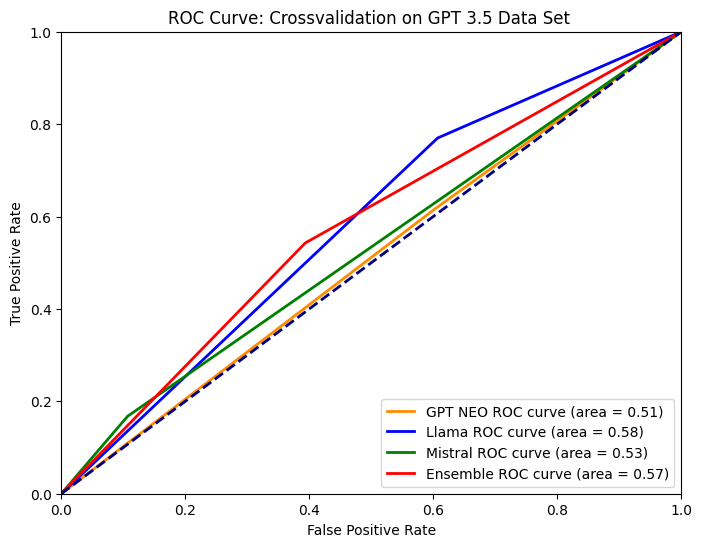

In [141]:
# Calculate ROC and AUC for Neo
fprNeo, tprNeo, thresholdsNeo = roc_curve(y_test, y_pred_combinedNeo)
roc_auc_neo = roc_auc_score(y_test, y_pred_combinedNeo)

# Calculate ROC and AUC for Llama
fprLlama, tprLlama, thresholdsLlama = roc_curve(y_test, y_pred_combinedLlama)
roc_auc_llama = roc_auc_score(y_test, y_pred_combinedLlama)

# Calculate ROC and AUC for Mistral
fprMistral, tprMistral, thresholdsMistral = roc_curve(y_test, y_pred_combinedMistral)
roc_auc_mistral = roc_auc_score(y_test, y_pred_combinedMistral)

# Calculate ROC and AUC for Ensemble
fprEnsemble, tprEnsemble, thresholdsEnsemble = roc_curve(y_test, y_pred_combinedEnsemble)
roc_auc_Ensemble = roc_auc_score(y_test, y_pred_combinedEnsemble)

plt.figure(figsize=(8, 6))

plt.plot(fprNeo, tprNeo, color='darkorange', lw=2, label=f'GPT NEO ROC curve (area = {roc_auc_neo:.2f})')
plt.plot(fprLlama, tprLlama, color='blue', lw=2, label=f'Llama ROC curve (area = {roc_auc_llama:.2f})')
plt.plot(fprMistral, tprMistral, color='green', lw=2, label=f'Mistral ROC curve (area = {roc_auc_mistral:.2f})')
plt.plot(fprEnsemble, tprEnsemble, color='red', lw=2, label=f'Ensemble ROC curve (area = {roc_auc_Ensemble:.2f})')


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Crossvalidation on GPT 3.5 Data Set ')
plt.legend(loc='lower right')
plt.savefig('../../../evaluation/Cross-Validation/ROC_Curve_onGPT.png')
plt.show()

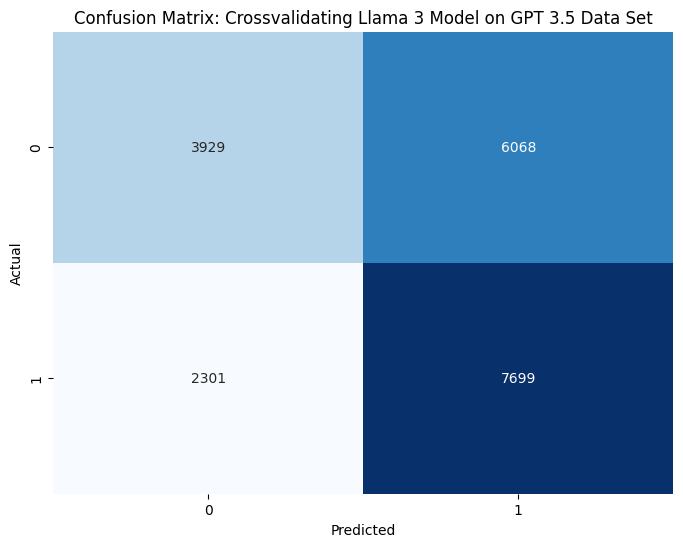

In [143]:
#confusion matrix

cm = confusion_matrix(y_test, y_pred_combinedLlama)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix: Crossvalidating Llama 3 Model on GPT 3.5 Data Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('../../../evaluation/Cross-Validation/Confusion_Matrix_Llama3_Cross-Validation.png')
plt.show()

In [144]:
print("Combined Model Classification Report:\n", classification_report(y_test, y_pred_combinedLlama))
print("Combined Model Accuracy:", accuracy_score(y_test, y_pred_combinedLlama))

Combined Model Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.39      0.48      9997
           1       0.56      0.77      0.65     10000

    accuracy                           0.58     19997
   macro avg       0.59      0.58      0.57     19997
weighted avg       0.59      0.58      0.57     19997

Combined Model Accuracy: 0.5814872230834626
